In [65]:
import os
import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels import api as sm
from scipy import fftpack
import scipy.io as sio
from scipy import fft
from scipy import arange
from statsmodels import api as sm
from scipy import signal
plt.style.use('seaborn-poster')
from numpy.fft import rfft, irfft, rfftfreq
from scipy import pi, signal, fftpack

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

%matplotlib inline

In [2]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')
from matplotlib import rcParams
rcParams['font.family'] = 'monospace'
rcParams['font.sans-serif'] = ['Lucida Console']

In [3]:
def annot_max(x, y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax) 
    #text = f"{xmax=}, {ymax=}, (period: {1./xmax} days)" #Eh, Colab has Python 3.6 ... 
    text = f"x={xmax:.3f}, y={ymax:.3f}, (period: {(1./xmax):.2f} days)"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)



In [4]:
def low_pass(s, threshold=2e4):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-3 / s.size)
    display(1/frequencies)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

In [24]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [27]:
def savitzky_golay_piecewise(xvals, data, kernel=11, order =4):
    turnpoint=0
    last=len(xvals)
    if xvals[1]>xvals[0] : #x is increasing?
        for i in range(1,last) : #yes
            if xvals[i]<xvals[i-1] : #search where x starts to fall
                turnpoint=i
                break
    else: #no, x is decreasing
        for i in range(1,last) : #search where it starts to rise
            if xvals[i]>xvals[i-1] :
                turnpoint=i
                break
    if turnpoint==0 : #no change in direction of x
        return savitzky_golay(data, kernel, order)
    else:
        #smooth the first piece
        firstpart=savitzky_golay(data[0:turnpoint],kernel,order)
        #recursively smooth the rest
        rest=savitzky_golay_piecewise(xvals[turnpoint:], data[turnpoint:], kernel, order)
        return np.concatenate((firstpart,rest))

In [28]:
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0
    
    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')
    
    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2
    
    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]
    
    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])
        
    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band ) 
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z
    
    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band ) 
    
    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band ) 
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band ) 
    
    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return signal.fftconvolve(Z, -c, mode='valid')        
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return signal.fftconvolve(Z, -r, mode='valid')        
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return signal.fftconvolve(Z, -r, mode='valid'), signal.fftconvolve(Z, -c, mode='valid')     

In [62]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [63]:
def wmape(actual, forecast):
    # we take two series and calculate an output a wmape from it
    # make a series called mape
    se_mape = abs(actual-forecast)/actual

    # get a float of the sum of the actual
    ft_actual_sum = actual.sum()

    # get a series of the multiple of the actual & the mape
    se_actual_prod_mape = actual * se_mape

    # summate the prod of the actual and the mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum()

    # float: wmape of forecast
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum

    # return a float
    return ft_wmape_forecast

In [69]:
# Define the function to return the SMAPE value
def smape(actual, predicted):
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [54]:
df = pd.read_csv('result_CA4000431_000000681000011800.csv')
df.columns = [c.lower() for c in df.columns]
df.fscl_wk_end_dt = pd.to_datetime(df.fscl_wk_end_dt)
df.set_index('fscl_wk_end_dt', inplace = True)
orig_df = df.copy()
df = df[['ty_div_tdp']]
#df['norm_avg_price'] = df['ty_div_avg_unit_price'] - np.mean(df['ty_div_avg_unit_price'])
df

,ty_div_tdp
fscl_wk_end_dt,
2018-01-06,0.460651
2018-01-13,0.427280
2018-01-20,0.359968
2018-01-27,0.444367
2018-02-03,0.306313
...,...
2021-11-27,0.369375
2021-12-04,0.407805
2021-12-11,0.339899


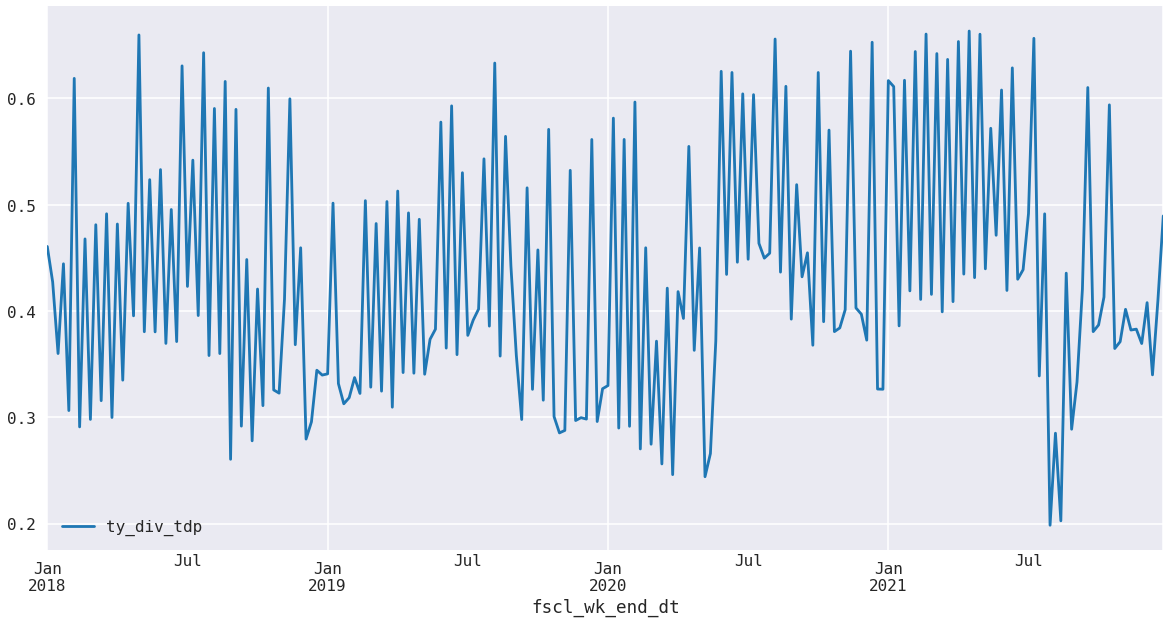

In [55]:
df.plot(figsize=(20,10))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


array([           inf, 2.00000000e-03, 1.00000000e-03, 6.66666667e-04,
       5.00000000e-04, 4.00000000e-04, 3.33333333e-04, 2.85714286e-04,
       2.50000000e-04, 2.22222222e-04, 2.00000000e-04, 1.81818182e-04,
       1.66666667e-04, 1.53846154e-04, 1.42857143e-04, 1.33333333e-04,
       1.25000000e-04, 1.17647059e-04, 1.11111111e-04, 1.05263158e-04,
       1.00000000e-04, 9.52380952e-05, 9.09090909e-05, 8.69565217e-05,
       8.33333333e-05, 8.00000000e-05, 7.69230769e-05, 7.40740741e-05,
       7.14285714e-05, 6.89655172e-05, 6.66666667e-05, 6.45161290e-05,
       6.25000000e-05, 6.06060606e-05, 5.88235294e-05, 5.71428571e-05,
       5.55555556e-05, 5.40540541e-05, 5.26315789e-05, 5.12820513e-05,
       5.00000000e-05, 4.87804878e-05, 4.76190476e-05, 4.65116279e-05,
       4.54545455e-05, 4.44444444e-05, 4.34782609e-05, 4.25531915e-05,
       4.16666667e-05, 4.08163265e-05, 4.00000000e-05, 3.92156863e-05,
       3.84615385e-05, 3.77358491e-05, 3.70370370e-05, 3.63636364e-05,
      

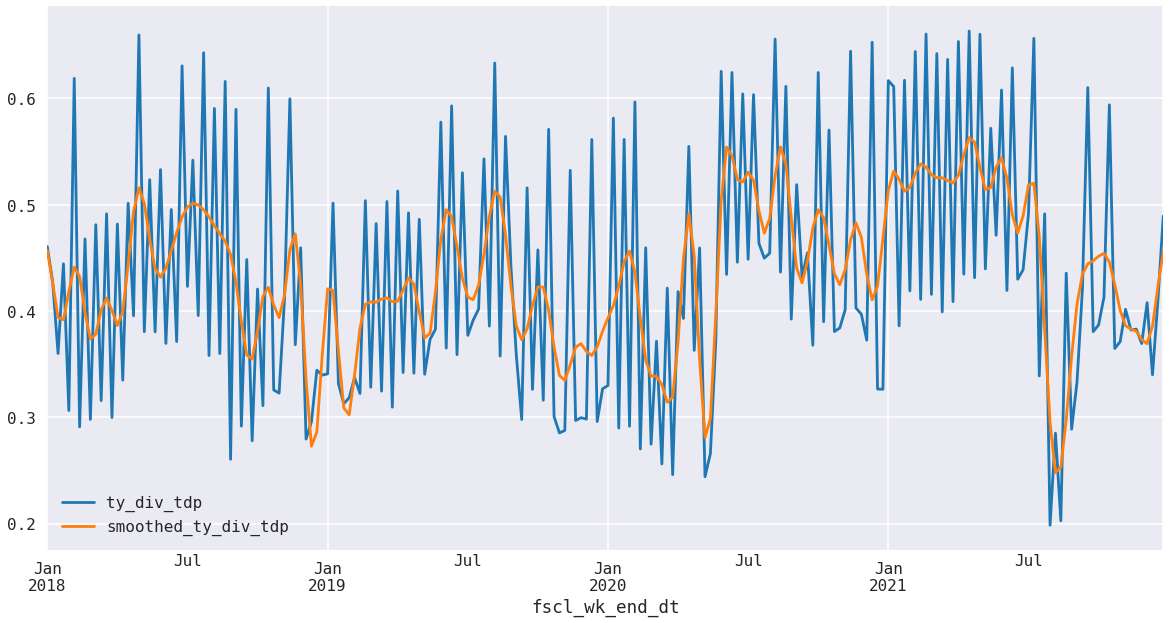

In [56]:
df['smoothed_ty_div_tdp'] = low_pass(df['ty_div_tdp'])
df.plot(figsize=(20,10))

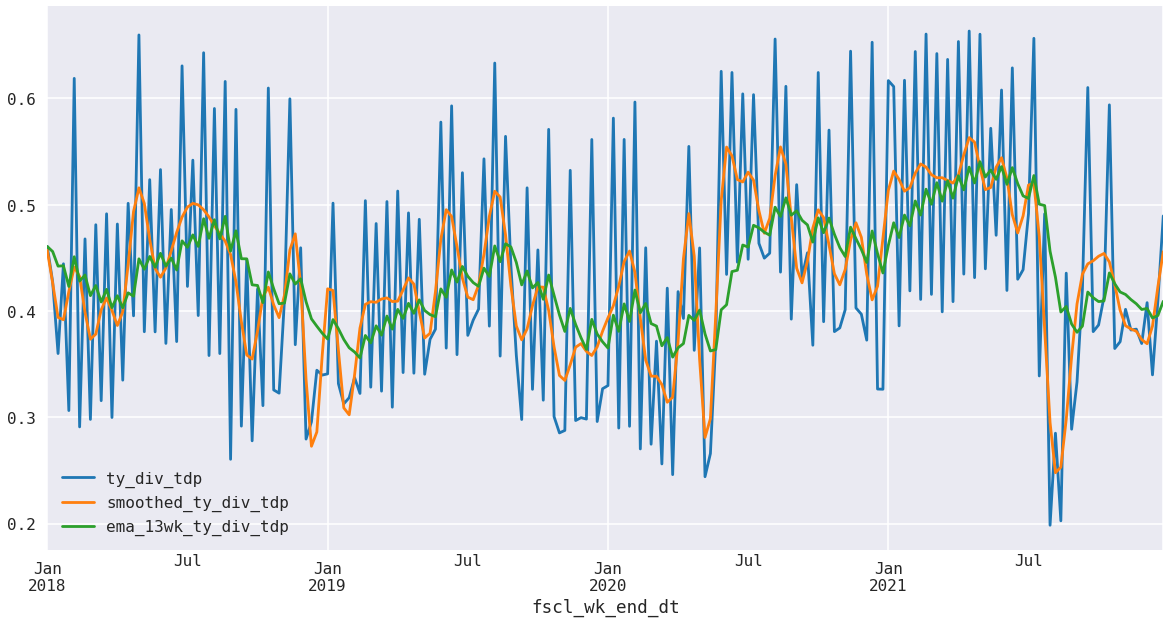

In [57]:
df['ema_13wk_ty_div_tdp'] = df['ty_div_tdp'].ewm(span=13, adjust=False, ignore_na=True).mean()
#df['ema_5wk_ty_div_tdp'] = df['ty_div_tdp'].ewm(span=5, adjust=False, ignore_na=True).mean()
df.plot(figsize=(20,10))

In [14]:
#df['ty_div_tdp_changes_delta'] = df['ty_div_tdp'].diff()
#df.plot(figsize=(20,10))

In [48]:
df

,ty_div_tdp,smoothed_ty_div_tdp,ema_13wk_ty_div_tdp
fscl_wk_end_dt,,,
2018-01-06,0.460651,0.457147,0.460651
2018-01-13,0.427280,0.426254,0.455883
2018-01-20,0.359968,0.393962,0.442181
2018-01-27,0.444367,0.391736,0.442493
2018-02-03,0.306313,0.418323,0.423039
...,...,...,...
2021-11-27,0.369375,0.373069,0.401412
2021-12-04,0.407805,0.369210,0.402326
2021-12-11,0.339899,0.385743,0.393408


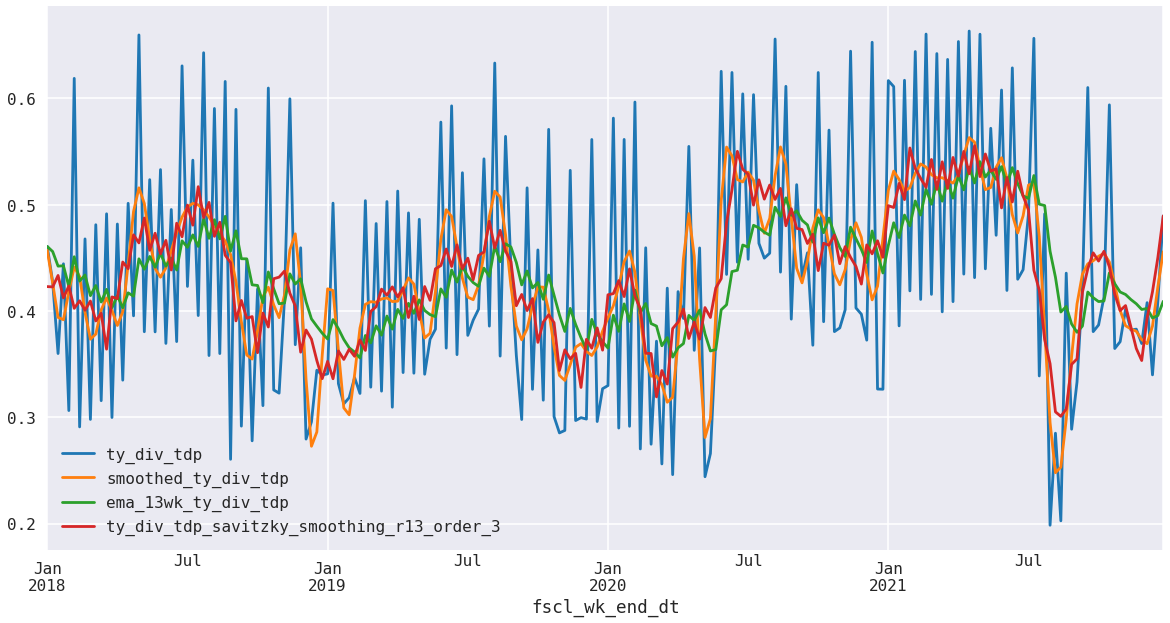

In [58]:
'''
https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
'''
df['ty_div_tdp_savitzky_smoothing_r13_order_3'] = savitzky_golay(df.ty_div_tdp, 13, 3)
df.plot(figsize=(20,10))

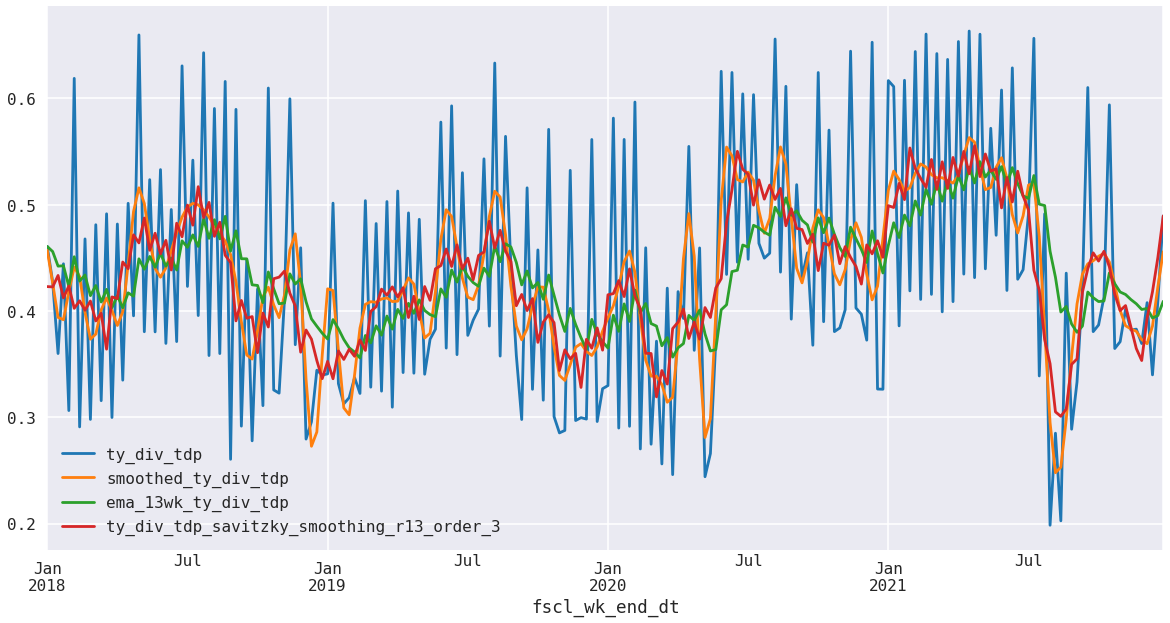

In [59]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
'''
plot(x, y,'o')
plot(x, smooth(y,3), 'r-', lw=2)
plot(x, smooth(y,19), 'g-', lw=2)
'''
#df['ty_div_tdp_smooth_lag_3'] = smooth(df['ty_div_tdp'],3)
#df['ty_div_tdp_smooth_lag_19'] = smooth(df['ty_div_tdp'],19)
df.plot(figsize=(20,10))

In [60]:
df

,ty_div_tdp,smoothed_ty_div_tdp,ema_13wk_ty_div_tdp,ty_div_tdp_savitzky_smoothing_r13_order_3
fscl_wk_end_dt,,,,
2018-01-06,0.460651,0.457147,0.460651,0.422916
2018-01-13,0.427280,0.426254,0.455883,0.422638
2018-01-20,0.359968,0.393962,0.442181,0.433378
2018-01-27,0.444367,0.391736,0.442493,0.412366
2018-02-03,0.306313,0.418323,0.423039,0.423498
...,...,...,...,...
2021-11-27,0.369375,0.373069,0.401412,0.353386
2021-12-04,0.407805,0.369210,0.402326,0.393341
2021-12-11,0.339899,0.385743,0.393408,0.418090


In [61]:
df = df[['ty_div_tdp', 'smoothed_ty_div_tdp']]
df

,ty_div_tdp,smoothed_ty_div_tdp
fscl_wk_end_dt,,
2018-01-06,0.460651,0.457147
2018-01-13,0.427280,0.426254
2018-01-20,0.359968,0.393962
2018-01-27,0.444367,0.391736
2018-02-03,0.306313,0.418323
...,...,...
2021-11-27,0.369375,0.373069
2021-12-04,0.407805,0.369210
2021-12-11,0.339899,0.385743


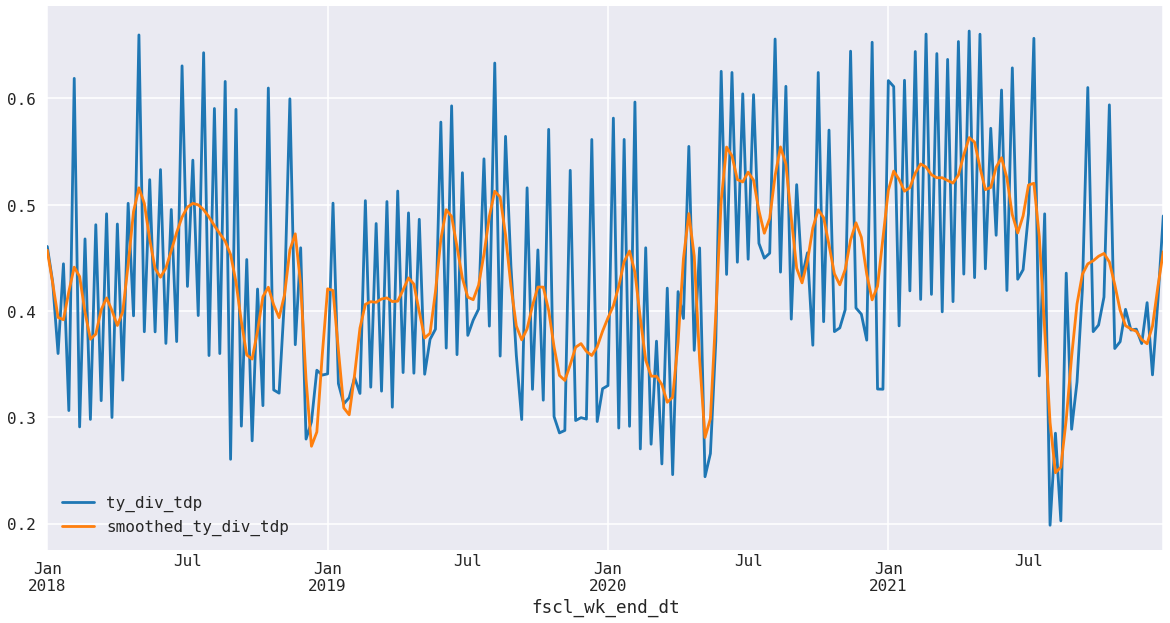

In [71]:
df.plot(figsize=(20,10))

In [70]:
mse = mean_squared_error(df.smoothed_ty_div_tdp, df.ty_div_tdp)
r2 = r2_score(df.smoothed_ty_div_tdp, df.ty_div_tdp)
mae = mean_absolute_error(df.smoothed_ty_div_tdp, df.ty_div_tdp)
mape = mean_absolute_percentage_error(df.smoothed_ty_div_tdp, df.ty_div_tdp)
wmape_val = wmape(df.ty_div_tdp, df.smoothed_ty_div_tdp)
smape_val = smape(df.ty_div_tdp, df.smoothed_ty_div_tdp)

print('The MSE is {}'. format(mse))
print('The RMSE is {}'. format(sqrt(mse)))
#print('The R2 is {}'. format(r2))
print('The MAE is {}'. format(mae))
print('The MAPE is {}'. format(mape))
print('The wMAPE is {}'. format(wmape_val))
print('The sMAPE is {}'. format(smape_val))

The MSE is 0.009072231755731897
The RMSE is 0.09524826379379257
The MAE is 0.0836519585008167
The MAPE is 19.192337388620594
The wMAPE is 0.19265170968649328
The sMAPE is 19.15
